In [1]:
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import arcgis
import sys
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer
gis = GIS()
nyc = gis.map('New York City')
nyc

ModuleNotFoundError: No module named 'arcgis'

In [2]:
!pip install arcgis

  Using cached arcgis-2.0.0.tar.gz (3.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached keyring-21.7.0-py3-none-any.whl (32 kB)
  Using cached lerc-4.0.1-py3-none-any.whl (736 kB)
  Using cached python_certifi_win32-1.6.1-py2.py3-none-any.whl (7.3 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  Using cached geomet-1.0.0-py3-none-any.whl (28 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached requests_ntlm-1.2.0-py3-none-any.whl (6.0 kB)
  Using cached requests_gssapi-1.2.3-py2.py3-none-any.whl
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
  Using cached gssapi-1.8.2-cp310-cp310-macosx_10_9_x86_64.whl (596 kB)
  Using cached pyspnego-0.9.0-py3-none-any.whl (132 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Created wheel for arcgis: filename=arcgis-2.0.0-py2.py3-none-any.whl size=

In [6]:
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import arcgis
import sys
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer
gis = GIS()
nyc = gis.map('New York City')

In [7]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

In [27]:
nyc_fl = FeatureLayer('https://gisservices.its.ny.gov/arcgis/rest/services/NYS_Civil_Boundaries/FeatureServer/4')
ny_df = pd.DataFrame.spatial.from_layer(nyc_fl)
nyc_df = ny_df.iloc[32:33]
nyc_df

,OBJECTID,NAME,MUNI_TYPE,MUNITYCODE,COUNTY,GNIS_ID,FIPS_CODE,SWIS,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,MAP_SYMBOL,CALC_SQ_MI,DATEMOD,SHAPE
32,33,Arkwright,town,2,Chautauqua,978689,3601302605,062000,1040.0,1126.0,1061.0,1008,None,NaT,T,35.761909,NaT,"{""rings"": [[[-8814115.4212, 5213293.0682], [-8..."


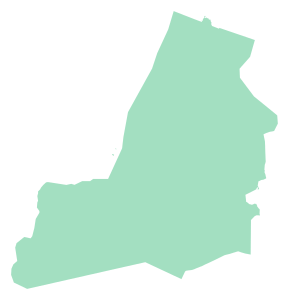

In [9]:
display(nyc_df.spatial)

In [10]:
area = geocode("New York City", out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']

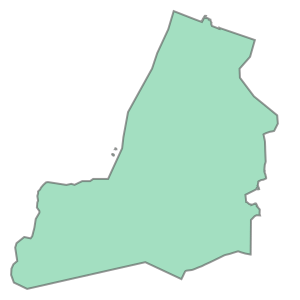

In [11]:
nyc_poly = nyc_df.iloc[0].SHAPE
type(nyc_poly)
display(nyc_poly)

In [12]:
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                            time=[datetime(2020, 4, 1), datetime(2020, 6, 30)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,2942883,2020-05-12 15:33:06,LC08_L1TP_013032_20200512_20200820_02_T1_MTL,0.0256,32,"{""rings"": [[[-8017114.2764, 5007565.486100003]..."


In [13]:
nyc_image = landsat.filter_by('OBJECTID=3372200')

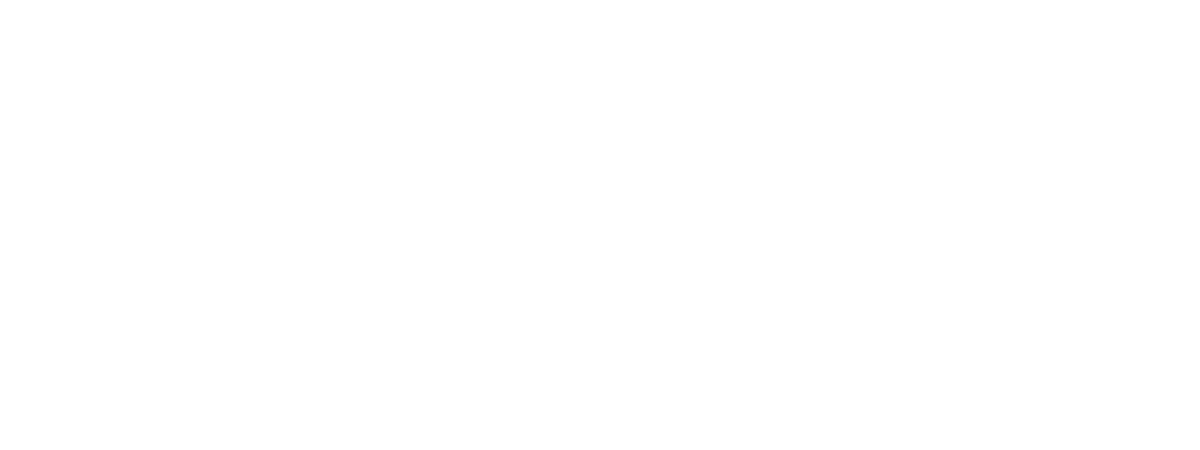

In [14]:
apply(nyc_image, 'Natural Color with DRA')

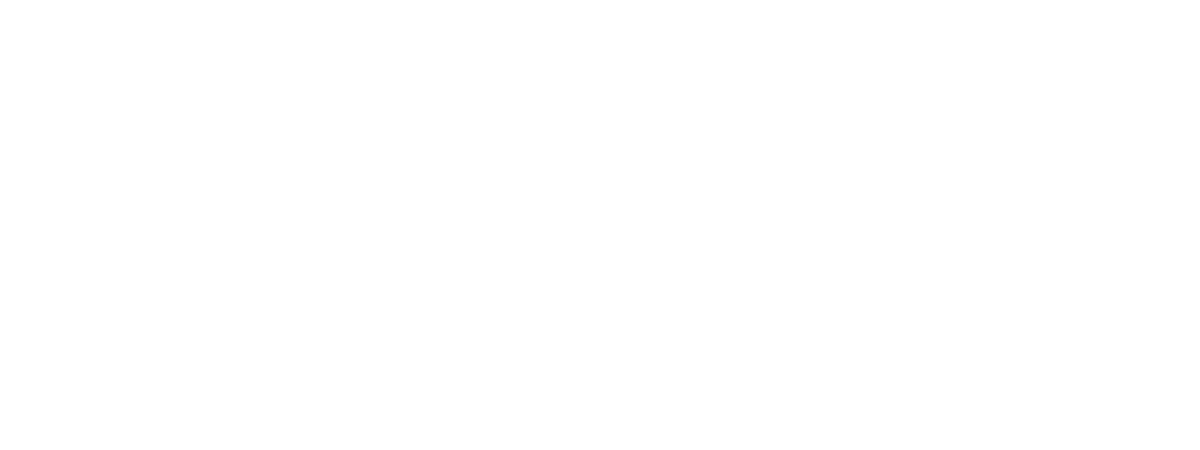

In [15]:
nyc_colorized = apply(nyc_image, 'NDVI Raw')
nyc_colorized

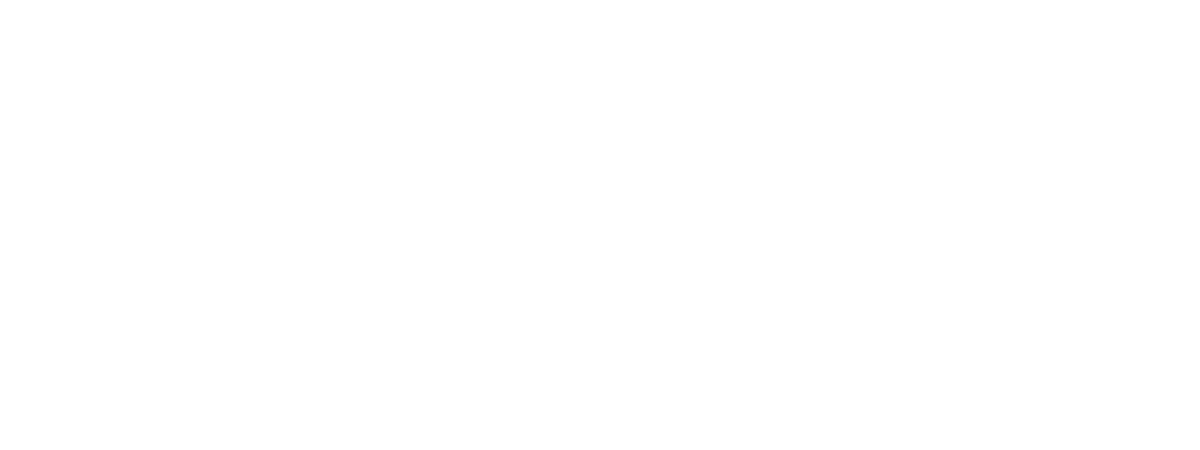

In [16]:
nyc_clip = clip(nyc_colorized,nyc_poly)
nyc_clip.extent = area['extent']
nyc_clip

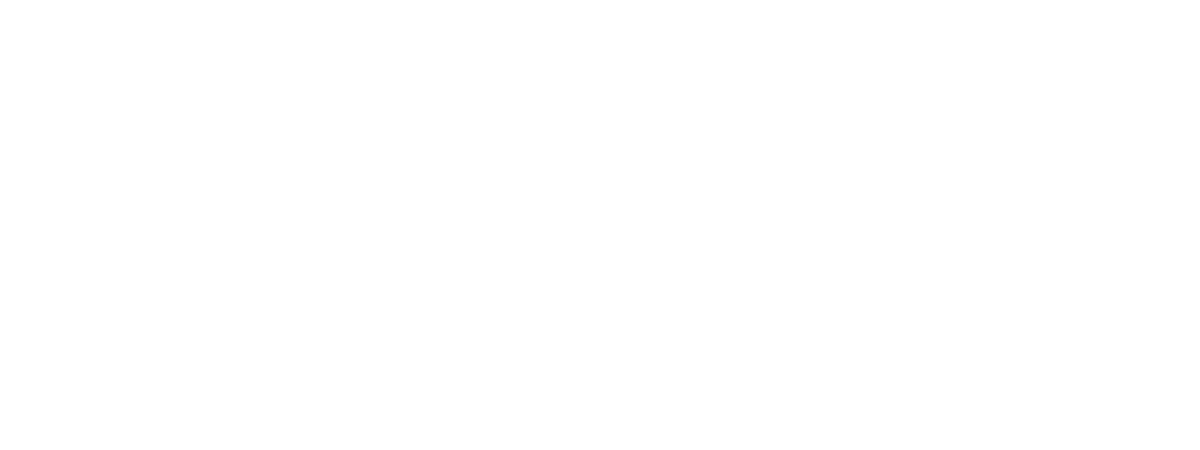

In [17]:
masked = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

In [18]:
mask_map = gis.map('New York City')
mask_map.add_layer(masked)
mask_map

MapView(layout=Layout(height='400px', width='100%'))

In [26]:
xpixel = (nyc_clip.extent['xmax'] - nyc_clip.extent['xmin']) / 800
ypixel = (nyc_clip.extent['ymax'] - nyc_clip.extent['ymin']) / 400

full_res = masked.compute_histograms(nyc_clip.extent,
                                   pixel_size={'x':xpixel, 'y': ypixel})
total_pix = 0
hist = full_res['histograms'][0]['counts'][0:]
for x in hist[1:]:
    total_pix += x
print("Histogram = ", hist[1])
colors=['#0EF716','#01FFF8','#909494']
labels =[ (hist[1]/sum(hist)), (hist[2]/sum(hist)), (hist[3]/sum(hist)) ]
plt.pie(hist, labels=['', 'Water', 'Concrete', 'Green Cover'],colors=colors,
        shadow=True)
plt.title('Landcover of New York City')
plt.show()

Histogram =  0


ZeroDivisionError: division by zero

In [20]:
colors=['#0EF716','#01FFF8','#909494']
labels =[ (hist[1]/sum(hist)), (hist[2]/sum(hist)), (hist[3]/sum(hist)) ]
plt.pie(hist, labels=['', 'Water', 'Concrete', 'Green Cover'],colors=colors,
        shadow=True)
plt.title('Landcover of New York City')
plt.show()

ZeroDivisionError: division by zero

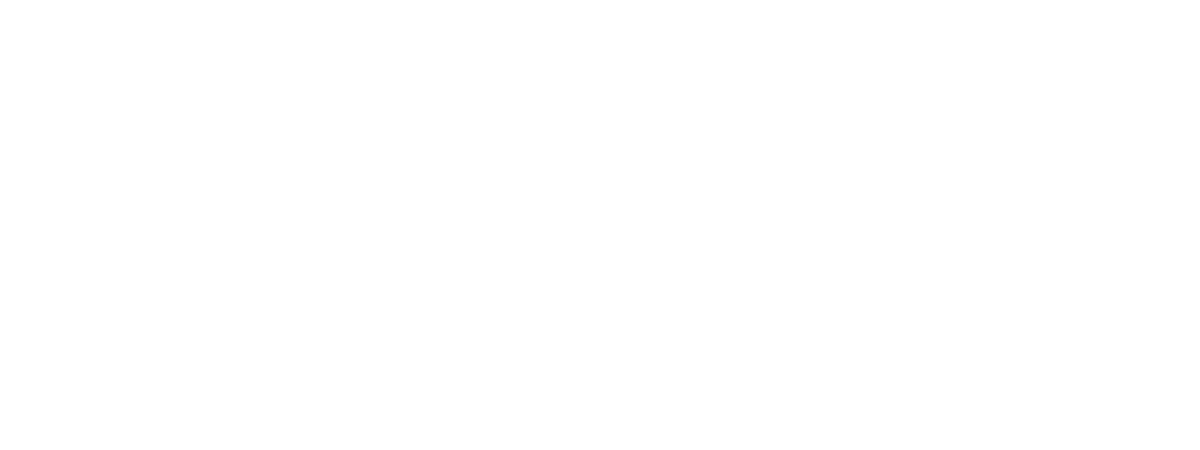

In [21]:
#map varient1
masked_water = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 255, 255, 255], [3,255,255,255]], astype='u8')

Image(masked_water.export_image(bbox=area['extent'], size=[1200,450], f='image'))

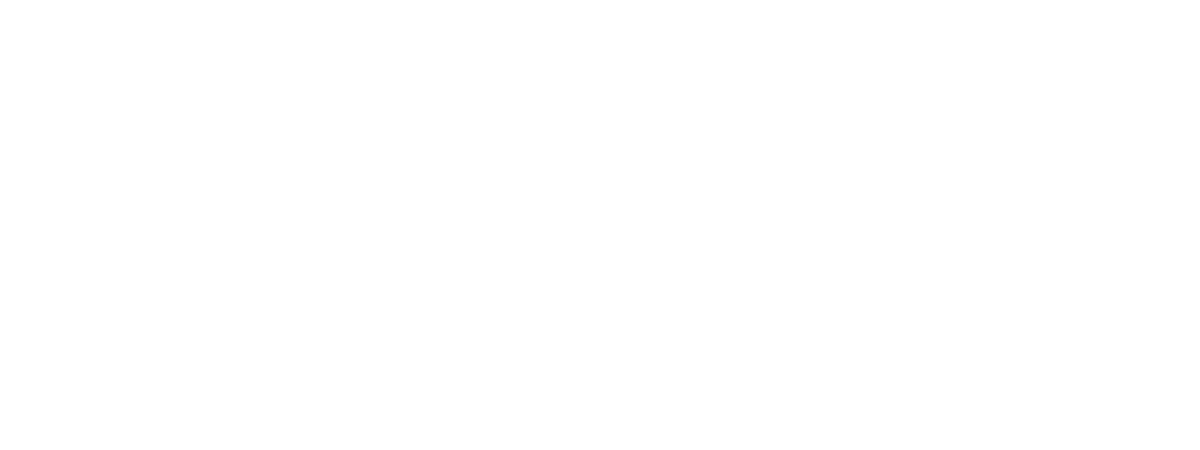

In [22]:
#map varient2
masked_concrete = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 144, 148, 148], [3,255,255,255]], astype='u8')

Image(masked_concrete.export_image(bbox=area['extent'], size=[1200,450], f='image'))

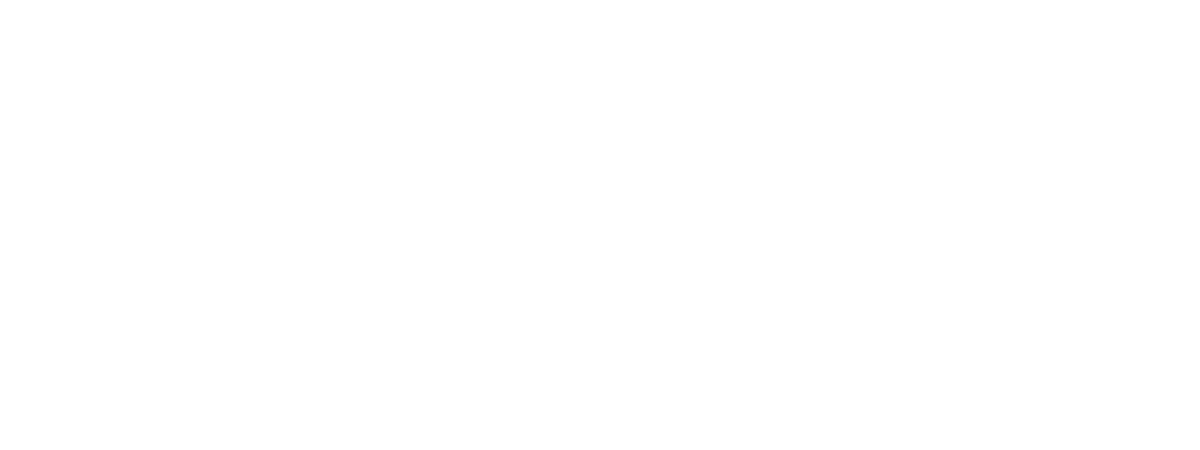

In [23]:
#map varient3
masked_green = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 255, 255, 255], [3,14,247,22]], astype='u8')

Image(masked_green.export_image(bbox=area['extent'], size=[1200,450], f='image'))